# Fake News Detection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

## Read datasets

In [2]:
fake = pd.read_csv("Fake.csv")
true = pd.read_csv("True.csv")

In [3]:
fake.shape

(23481, 4)

In [4]:
true.shape

(21417, 4)

### Data cleaning and preparation

In [5]:
fake['target'] = 'fake'
true['target'] = 'true'

In [6]:
data = pd.concat([fake, true]).reset_index(drop = True)
data.shape

(44898, 5)

In [7]:
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [8]:
data.head()

,title,text,subject,date,target
0,"Trump says will work with Congress on grants, ...",WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"October 19, 2017",true
1,PRESIDENT TRUMP Receives Patriots Jersey From ...,In an outdoor ceremony to celebrate the super ...,politics,"Apr 19, 2017",fake
2,Donald Trump’s Latest Namesake Has Bad Hair A...,Before running the most controversial and bomb...,News,"January 17, 2017",fake
3,Judge delays NJ Senator Menendez's dismissal b...,(Reuters) - A judge has decided to delay rulin...,politicsNews,"August 9, 2017",true
4,Obama would veto House bill to block funding o...,WASHINGTON (Reuters) - President Barack Obama’...,politicsNews,"September 13, 2016",true


In [9]:
data.drop(["date"],axis=1,inplace=True)
data.head()

,title,text,subject,target
0,"Trump says will work with Congress on grants, ...",WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,true
1,PRESIDENT TRUMP Receives Patriots Jersey From ...,In an outdoor ceremony to celebrate the super ...,politics,fake
2,Donald Trump’s Latest Namesake Has Bad Hair A...,Before running the most controversial and bomb...,News,fake
3,Judge delays NJ Senator Menendez's dismissal b...,(Reuters) - A judge has decided to delay rulin...,politicsNews,true
4,Obama would veto House bill to block funding o...,WASHINGTON (Reuters) - President Barack Obama’...,politicsNews,true


In [10]:
data.drop(["title"],axis=1,inplace=True)
data.head()

,text,subject,target
0,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,true
1,In an outdoor ceremony to celebrate the super ...,politics,fake
2,Before running the most controversial and bomb...,News,fake
3,(Reuters) - A judge has decided to delay rulin...,politicsNews,true
4,WASHINGTON (Reuters) - President Barack Obama’...,politicsNews,true


In [11]:
data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,text,subject,target
0,washington (reuters) - u.s. president donald t...,politicsNews,true
1,in an outdoor ceremony to celebrate the super ...,politics,fake
2,before running the most controversial and bomb...,News,fake
3,(reuters) - a judge has decided to delay rulin...,politicsNews,true
4,washington (reuters) - president barack obama’...,politicsNews,true


In [12]:
import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)

In [13]:
data.head()

,text,subject,target
0,washington reuters us president donald trump ...,politicsNews,true
1,in an outdoor ceremony to celebrate the super ...,politics,fake
2,before running the most controversial and bomb...,News,fake
3,reuters a judge has decided to delay ruling o...,politicsNews,true
4,washington reuters president barack obama’s a...,politicsNews,true


In [14]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
data.head()

,text,subject,target
0,washington reuters us president donald trump s...,politicsNews,true
1,outdoor ceremony celebrate super bowl champ ne...,politics,fake
2,running controversial bombastic political camp...,News,fake
3,reuters judge decided delay ruling whether fed...,politicsNews,true
4,washington reuters president barack obama’s ad...,politicsNews,true


## Basic data exploration

subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


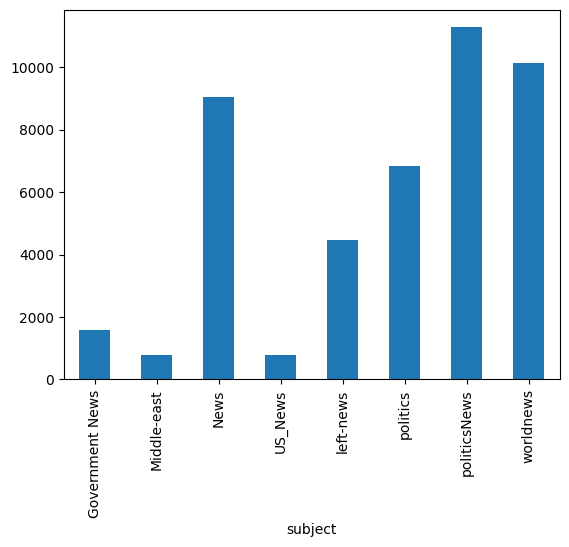

In [16]:
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

target
fake    23481
true    21417
Name: text, dtype: int64


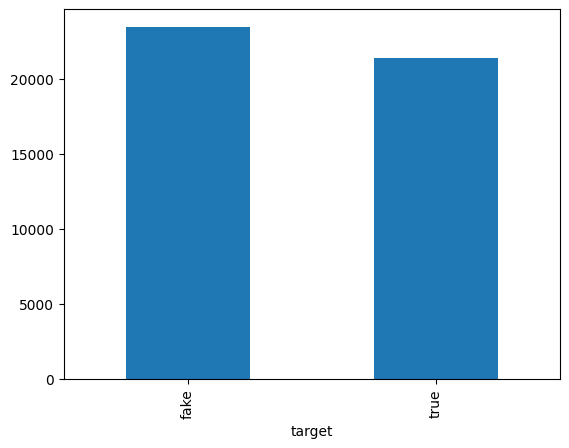

In [17]:
print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind="bar")
plt.show()

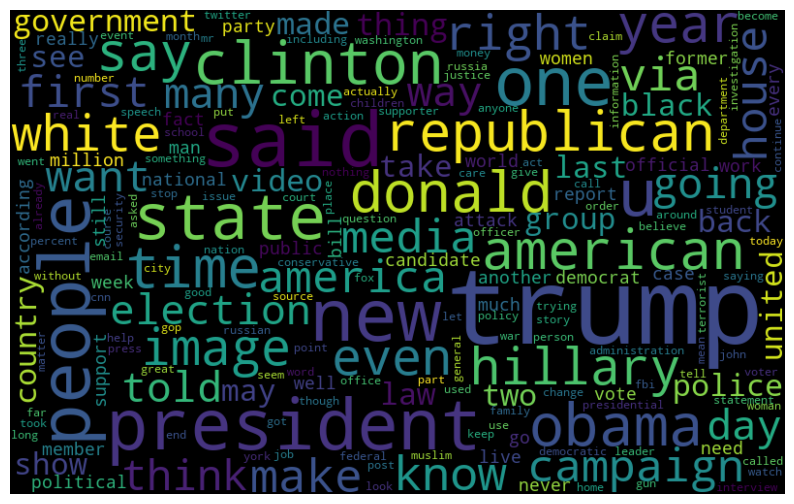

In [18]:
from wordcloud import WordCloud

fake_data = data[data["target"] == "fake"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

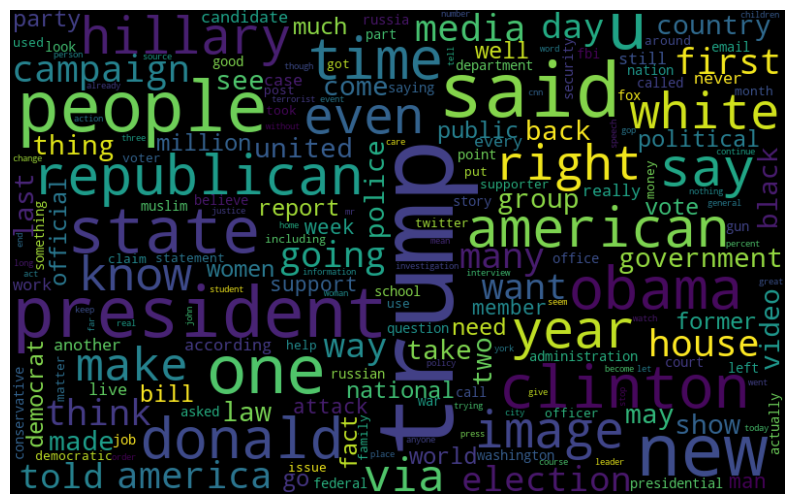

In [19]:
from wordcloud import WordCloud

real_data = data[data["target"] == "true"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [20]:
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

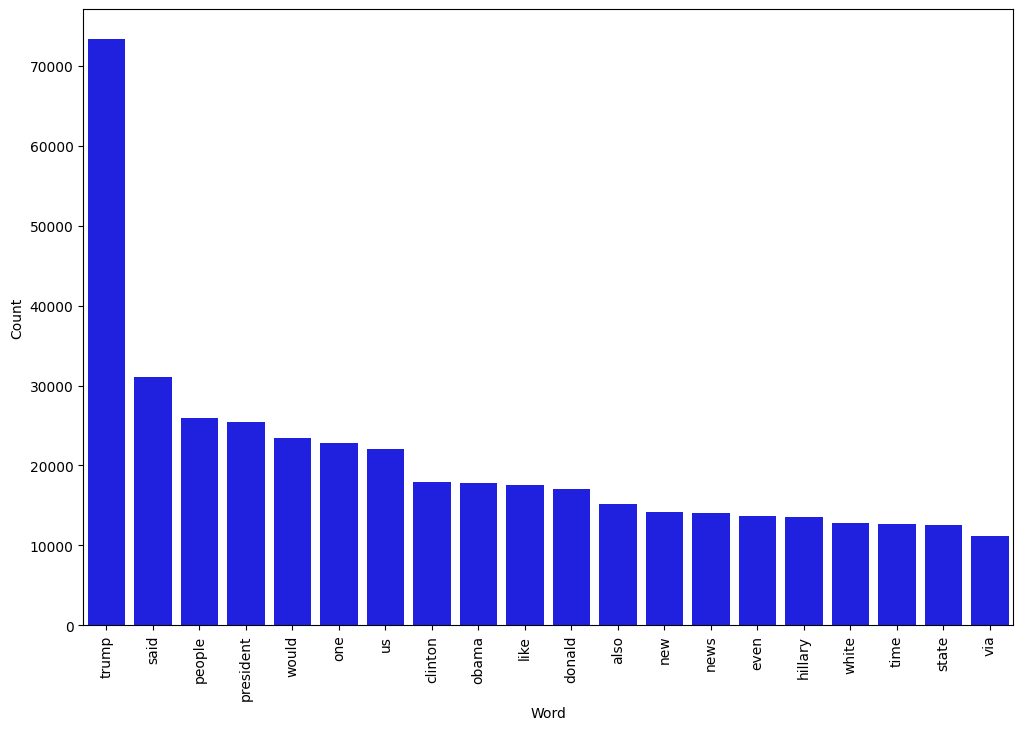

In [21]:
counter(data[data["target"] == "fake"], "text", 20)

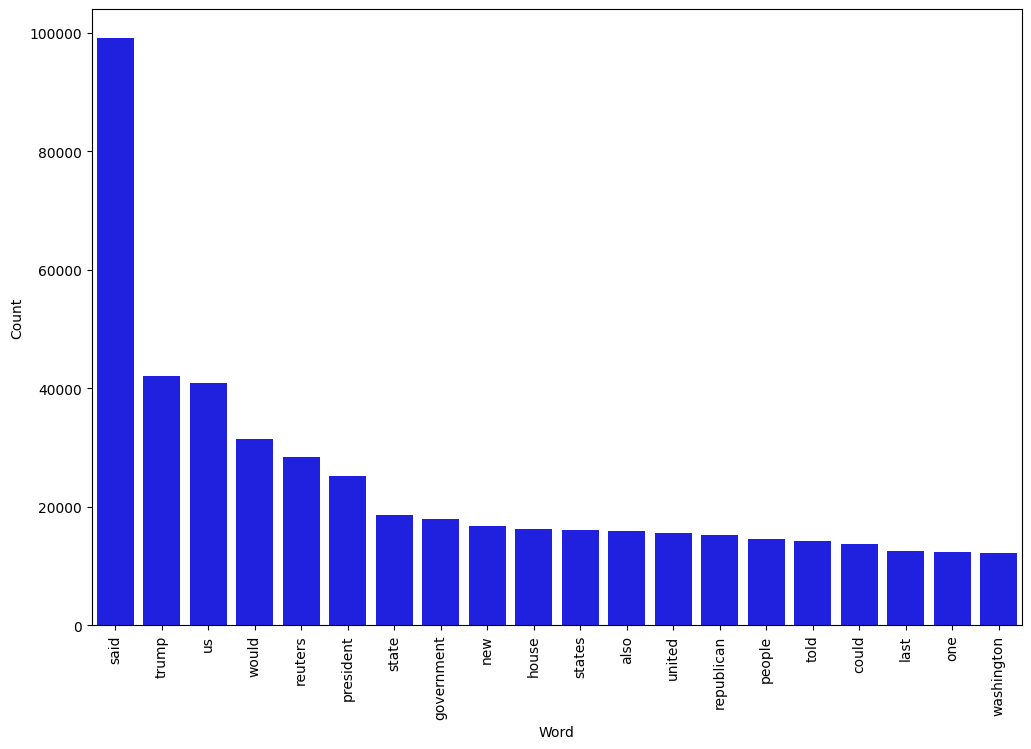

In [22]:
counter(data[data["target"] == "true"], "text", 20)

## Modeling

In [23]:
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


### Peparing the data

In [24]:
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)

### Logistic regression

In [25]:
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 99.0%


Confusion matrix, without normalization


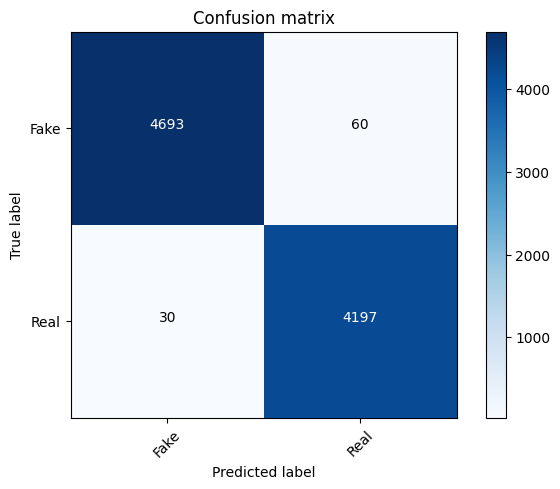

In [26]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

### Decision Tree Classifier

In [27]:
from sklearn.tree import DecisionTreeClassifier

# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])
# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 99.65%


Confusion matrix, without normalization


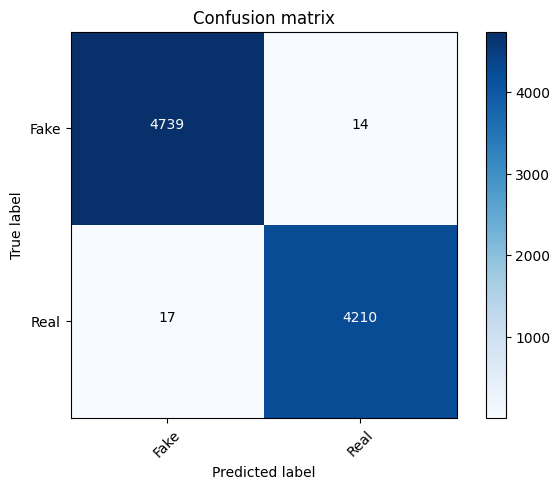

In [28]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

### Random Forest Classifier

In [29]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 99.09%


Confusion matrix, without normalization


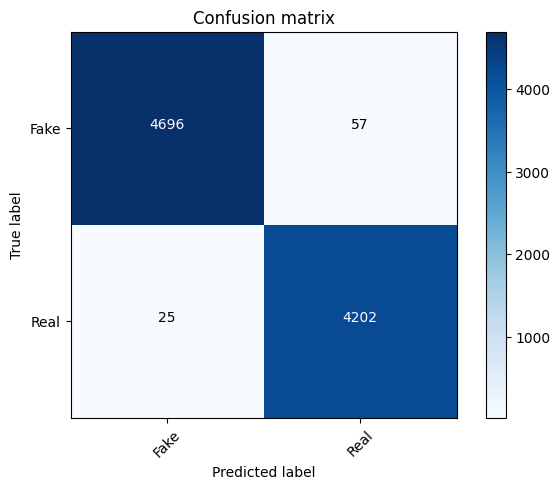

In [30]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])